# Flows learned solutions and true solutions to nonlinear ICA

The code below tries out aDM on solutions to the nonlinear ICA problem given by normalizing flows.

There is a number of caveats to the current version:

## 1. Hard to implement a learnable Darmois construction with flows: 

Many reasons: (i) long training time; (ii) extremely not expressive when constrained to triangular Jacobian (despite proofs of UAC...)
**(iii) training is unstable and sometimes returns nan**. (iv) I train on few datapoints, otherwise it takes forever.
In practice, I am using RealNVP modules (which I think should **not** have UAC).
Concatenating enough modules (with shuffling of the variables in between) the transformation looks almost expressive enough (while **not** having triangular Jacobian).

## 2. Principled way to compare models

In practice, the comparison btwn real solution and flow-learned one only makes sense if the flow **perfectly** fits the data.
This does not happen most of the time anyhow.
Alternatively, one would need a principled way to compare two models based on a combination of their aDM value and likelihood.

## 3. (Related to the above) did the flow learn the "true" solution?

Given that this flows don't have triangular Jacobian, it is in principle possible that they learn the true solution.
Currently, I check that this is not the case by visual inspection --- but this is not very principled. Other ideas?

In [1]:
from jax import numpy as np
from jax import random

import numpy as onp

In [2]:
rng, flow_rng = random.split(random.PRNGKey(0))

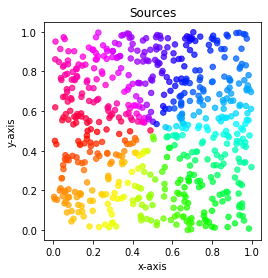

In [3]:
# N:=Number of samples
N = 600
# D:=Number of dimensions
D = 2

# Generate the samples
S = random.uniform(rng, shape=(N, D), minval=0.0, maxval=1.0)

from plotting import cart2pol, scatterplot_variables

_, phi = cart2pol( S[:,0]-0.5, S[:,1]-0.5)

colors = phi

scatterplot_variables(S, 'Sources', colors=colors)

In [4]:
# Generate the observations
from mixing_functions import f_1, f_2, f_3
from jax import vmap

mixing = f_2

mixing_batched = vmap(mixing)

X = mixing_batched(S)

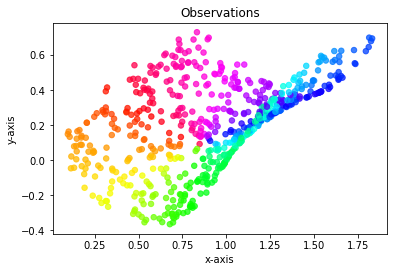

In [5]:
scatterplot_variables(X, 'Observations', colors=colors)

In [6]:
# Insert a lot of code to do wonderful things with Gilles Louppe's Normalizing Flow implementations

In [7]:
from real_nvp import real_nvp_and_inv

realnvp, realnvp_inv = real_nvp_and_inv(D)

In [8]:
from jax import jacfwd

v_realnvp = vmap(realnvp, (0, None, None, None, None))
v_realnvp_inv = vmap(realnvp_inv, (0, None, None, None, None))
J_realnvp = jacfwd(realnvp)
v_J_realnvp = vmap(J_realnvp, (0, None, None, None, None))
vdet = vmap(np.linalg.det)

In [9]:
from real_nvp import nf_init, nf_forward, nf_backward

In [10]:
# Initialize a normalizing flow made of 5 real NVP transformations
d = D//2
nf_nn, nf_params = nf_init(20, rng, d)

In [11]:
from jax.scipy.stats import multivariate_normal

def loss(params, batch):
    z, jacobians = nf_forward(batch, nf_nn, params, forward=v_realnvp, return_jacobians=True, jacobian_function=v_J_realnvp)
    return -np.mean(multivariate_normal.logpdf(z, mean=np.zeros(D), cov=np.eye(D)) + 
                    sum([np.log(np.abs(vdet(J))) for J in jacobians]))

In [12]:
from jax.experimental.optimizers import adam
from jax import grad
from jax import jit


opt_init, opt_update, get_params = adam(step_size=1e-4)
grad_loss = grad(loss, 0)

@jit
def step(i, opt_state, batch):
    params = get_params(opt_state)
    g = grad_loss(params, batch)
    return opt_update(i, g, opt_state)

In [13]:
opt_state = opt_init(nf_params)
save_opt_state = opt_state
best_params = get_params(opt_state)
best_loss = 1e3

In [14]:
iters, batch_size = 2000, 60
data_generator = (X[onp.random.choice(X.shape[0], batch_size)] for _ in range(iters+1))

In [15]:
opt_state = save_opt_state

In [16]:
for i in range(iters):
    current_minibatch = next(data_generator)
    opt_state = step(i, opt_state, current_minibatch)
    
    # Show progress
    if i % 50 == 0:
        params = get_params(opt_state)
        loss_current = loss(params, current_minibatch)
        print('Epoch: ', i, '; Loss: ', loss_current)
        if loss_current<best_loss:
            best_loss = loss_current
            best_params = get_params(opt_state)
            save_opt_state = opt_state

Epoch:  0 ; Loss:  1.7024417
Epoch:  50 ; Loss:  0.04749875
Epoch:  100 ; Loss:  -0.106986895
Epoch:  150 ; Loss:  1.731749
Epoch:  200 ; Loss:  0.453137
Epoch:  250 ; Loss:  0.119742915
Epoch:  300 ; Loss:  0.18677184
Epoch:  350 ; Loss:  -0.2607561
Epoch:  400 ; Loss:  -0.105599165
Epoch:  450 ; Loss:  -0.037509542
Epoch:  500 ; Loss:  -0.03563898
Epoch:  550 ; Loss:  -0.0259052
Epoch:  600 ; Loss:  0.13462448
Epoch:  650 ; Loss:  -0.16553172
Epoch:  700 ; Loss:  -0.05999751
Epoch:  750 ; Loss:  -0.055615935
Epoch:  800 ; Loss:  0.13818379
Epoch:  850 ; Loss:  -0.25734478
Epoch:  900 ; Loss:  -0.42927453
Epoch:  950 ; Loss:  -0.03746337
Epoch:  1000 ; Loss:  -0.1663619
Epoch:  1050 ; Loss:  -0.41689226
Epoch:  1100 ; Loss:  -0.08441205
Epoch:  1150 ; Loss:  -0.19154437
Epoch:  1200 ; Loss:  -0.30741546
Epoch:  1250 ; Loss:  -0.32855147
Epoch:  1300 ; Loss:  -0.07623043
Epoch:  1350 ; Loss:  -0.34847158
Epoch:  1400 ; Loss:  0.2162597
Epoch:  1450 ; Loss:  -0.03270192
Epoch:  1500 ; L

In [17]:
params = best_params #get_params(opt_state)

In [18]:
best_loss #loss(params, X[:100])

DeviceArray(-0.42927453, dtype=float32)

In [19]:
loss(params, X)

DeviceArray(-0.21569316, dtype=float32)

In [20]:
# Forward and inverse functions

# ...

In [21]:
# Project through the flow
Y = nf_forward(X, nf_nn, params, forward=v_realnvp, return_jacobians=False)

In [22]:
from plotting import scatterplot_variables

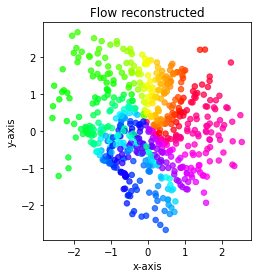

In [23]:
scatterplot_variables(Y, 'Flow reconstructed', colors=colors)

In [24]:
X_ = nf_backward(Y, nf_nn, params, v_realnvp_inv)

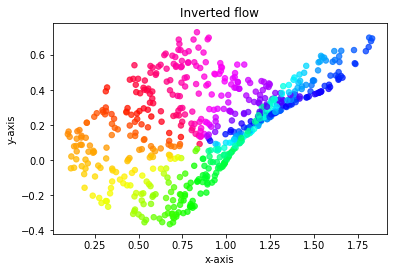

In [25]:
scatterplot_variables(X_, 'Inverted flow', colors=colors)

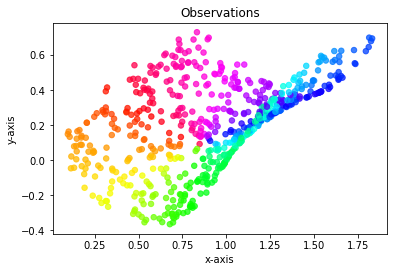

In [26]:
scatterplot_variables(X, 'Observations', colors=colors)

In [27]:
# Implied mixing
mixing_darmois = lambda x : nf_backward(x, nf_nn, params, realnvp_inv)
# mixing_darmois_batched = vmap(mixing_darmois)

In [28]:
Y[0].shape

(2,)

In [29]:
mixing_darmois(Y[0])

DeviceArray([1.4854488, 0.427014 ], dtype=float32)

In [30]:
# mixing_darmois(Y[0:1])

In [31]:
from jax import jacfwd

Jflow = jacfwd(mixing_darmois)
# Jflow_batched = vmap(Jflow)

In [32]:
Jflow(Y[0])

DeviceArray([[-0.19421421, -0.30728218],
             [ 0.04022301, -0.13307089]], dtype=float32)

In [33]:
# Jflow(Y[0:1]).reshape(-1, 2, 2)

In [34]:
# Import aDM and stuff
from metrics import aDM

In [35]:
# Compute the batched Jacobian
Jmixing = jacfwd(mixing)
Jmixing_batched = vmap(Jmixing)
# Compute aDM true
true_aDM = aDM(Jmixing_batched, S)

# Build Darmois
# Insert Flow here!

# Sources w. Darmois construction
Y = nf_forward(X, nf_nn, params, forward=v_realnvp, return_jacobians=False)

# Compute the batched Jacobian
Jflow = jacfwd(mixing_darmois)
Jflow_batched = vmap(Jflow)
# Compute aDM for inv Darmois
flow_darmois_aDM = aDM(Jflow_batched, Y)

print(true_aDM)

print(flow_darmois_aDM)

0.73210675
0.8711539


In [36]:
np.mean(Jflow_batched(Y), axis=0)

DeviceArray([[-0.13182199, -0.3011529 ],
             [ 0.14406839, -0.14491667]], dtype=float32)

## Below, code for training of Normalising Flows based on
https://circleci.com/gh/ChrisWaites/jax-flows

In [8]:
# from flow_models import MAF_init_fun, NeuralSplineCoupling_init_fun

In [9]:
# init_fun, bijection = MAF_init_fun()
# # init_fun, bijection = NeuralSplineCoupling_init_fun()

In [10]:
# params, log_pdf, sample = init_fun(flow_rng, D)

In [11]:
# from jax import jit, grad
# import itertools

# def loss(params, inputs):
#     return -log_pdf(params, inputs).mean()

# # @jit
# def step(i, opt_state, inputs):
#     params = get_params(opt_state)
#     gradients = grad(loss)(params, inputs)
#     return opt_update(i, gradients, opt_state)

# itercount = itertools.count()

In [12]:
# num_epochs, batch_size = 500, 50

In [13]:
# from jax.experimental import optimizers

# opt_init, opt_update, get_params = optimizers.adam(step_size=5*1e-5)
# opt_state = opt_init(params)

In [14]:
# for epoch in range(num_epochs):
# #     clear_output(wait=True) # Clear plotting

#     permute_rng, rng = random.split(rng)
#     X = random.permutation(permute_rng, X)
#     for batch_index in range(0, len(X), batch_size):
#         opt_state = step(next(itercount), opt_state, X[batch_index:batch_index+batch_size])
    
#     if (epoch+1)%10 ==0:
#         params = get_params(opt_state)
#         current_loss = loss(params, X)
#         print("Epoch: ", epoch+1, "; Loss: ", current_loss)